In [1]:
import os
user_dir = os.path.expanduser("~")
os.environ["R_HOME"] = "{}/anaconda3/envs/gpr/Lib/R".format(user_dir)
os.environ["PATH"]   = "{}/anaconda3/envs/gpr/Lib/R/bin/x64".format(user_dir) + ";" + os.environ["PATH"]
from advanced_pca import CustomPCA


import matplotlib.pyplot as plt
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.model_selection import KFold 
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo
from PIL import Image
from sklearn.preprocessing import MinMaxScaler
import plotly.io as pio
import math
from wordcloud import WordCloud
from plotly.express.colors import sample_colorscale
pio.templates.default = "plotly_dark"


In [2]:
use_previous_pcas = False
data=pd.read_csv('output_PCA.csv') # Reading datafile (should be in the same directory as our IDE)
try:
    use_previous_pcas = True
    PCAdata = data.drop(["Participant #","Runtime_mod","Task_name","Gradient 1","Gradient 2","Gradient 3","FAC1_1","FAC2_1","FAC3_1","FAC4_1"],axis=1) # Getting rid of unneeded columns for PCA
    PCAresults = data[["FAC1_1","FAC2_1","FAC3_1","FAC4_1"]]
    PCAresults = PCAresults.rename(columns={"FAC1_1": 0, "FAC2_1": 1,"FAC3_1":2,"FAC4_1":3})
    loadings = pd.read_csv("new_loadings.csv",header=None,index_col=0).rename(columns={1:"Component 0", 2:"Component 1", 3:"Component 2", 4:"Component 3"})
except:
    use_previous_pcas = True
    PCAdata = data.drop(["Participant#","Runtime_mod","Task_name","Gradient1","Gradient2","Gradient3","FAC1_1","FAC2_1","FAC3_1","FAC4_1"],axis=1) # Getting rid of unneeded columns for PCA
    data = data.rename(columns={"Gradient1": "Gradient 1", "Gradient2": "Gradient 2","Gradient3":"Gradient 3"})
    PCAresults = data[["FAC1_1","FAC2_1","FAC3_1","FAC4_1"]]
    PCAresults = PCAresults.rename(columns={"FAC1_1": 0, "FAC2_1": 1,"FAC3_1":2,"FAC4_1":3})
    loadings = pd.read_csv("old_loadings.csv",header=None,index_col=0).rename(columns={1:"Component 0", 2:"Component 1", 3:"Component 2", 4:"Component 3"})

In [3]:
chi_square_value,p_value=calculate_bartlett_sphericity(PCAdata) # I belive this checks for correlations within our dataset which would make a PCA weird
chi_square_value, p_value # significant p-value means we're ok

(2863.4898796646885, 0.0)

In [4]:
kmo_all,kmo_model=calculate_kmo(PCAdata) # Not even going to pretend I understand the Kaiser-Meyer-Olkin criteria
kmo_all,kmo_model # kmo_model > 0.6 is acceptable

(array([0.85585898, 0.76201432, 0.61533417, 0.80801207, 0.81901643,
        0.72690386, 0.78571716, 0.72342191, 0.71980541, 0.74463419,
        0.74314689, 0.80242482, 0.7687802 , 0.71078397, 0.79430761,
        0.77720446]),
 0.7636127234923935)

In [5]:
if use_previous_pcas == False:
    PCAmodel = CustomPCA(n_components=4,rotation="varimax") 
    PCAmodel.fit(PCAdata)
    loadings = PCAmodel.components_

    # for en,row in enumerate(loadings):
    #     if np.mean(row) < 0:
    #         loadings[en] = np.multiply(row, -1)
    
    names = PCAdata.columns
    loadings = pd.DataFrame(np.round(loadings.T,3),index=names,columns=["Component 0","Component 1","Component 2","Component 3"])
    PCAresults = PCAmodel.transform(PCAdata).T 

In [6]:
FAC=np.asarray([PCAresults[0], PCAresults[1],PCAresults[2],PCAresults[3]]).T
GRAD=np.asarray([data["Gradient 1"], data["Gradient 2"],data["Gradient 3"]]).T
KeepIndex=~np.isnan(FAC[:,0])
tasknum = len(data["Task_name"].unique())

In [7]:

Tasklabels,Taskindices=np.unique(data["Task_name"],return_inverse=True)
FAC_TaskCentres=np.zeros([tasknum,4])
for i in range(tasknum):
    FAC_TaskCentres[i,:]=FAC[Taskindices==i,:].mean(axis=0)

Grad_TaskCentres=np.zeros([tasknum,3])
for i in range(tasknum):

    Grad_TaskCentres[i,:]=GRAD[np.ix_(Taskindices==(i),[0,1,2])].mean(axis=0)


In [16]:
#Fit whole dataset



fig_estimated_mean = make_subplots(rows=4, cols=2,column_widths=[0.7, 0.25], vertical_spacing=0,horizontal_spacing=0.2, subplot_titles=(["Component 1","Component 1 Wordcloud", "Component 2","Component 2 Wordcloud", "Component 3","Component 3 Wordcloud", "Component 4","Component 4 Wordcloud"]),specs=[[{'type': 'surface'},{'type': 'xy'}],[{'type': 'surface'},{'type': 'xy'}],[{'type': 'surface'},{'type': 'xy'}],[{'type': 'surface'},{'type': 'xy'}]])

fig_standard_deviation = make_subplots(rows=4, cols=2,column_widths=[0.7, 0.25], vertical_spacing=0,horizontal_spacing=0.2,subplot_titles=(["Component 1","Component 1 Wordcloud", "Component 2","Component 2 Wordcloud", "Component 3","Component 3 Wordcloud", "Component 4","Component 4 Wordcloud"]),specs=[[{'type': 'surface'},{'type': 'xy'}],[{'type': 'surface'},{'type': 'xy'}],[{'type': 'surface'},{'type': 'xy'}],[{'type': 'surface'},{'type': 'xy'}]])



for i in range(4):


    standardscaler=StandardScaler()
    X=Grad_TaskCentres

    y = standardscaler.fit_transform(FAC_TaskCentres[:,i].reshape(-1,1))    


    kernel = 1.0 * Matern(length_scale=0.5, length_scale_bounds=(0.5, 1), nu=2.5) + WhiteKernel(noise_level_bounds=[0.001,0.1],noise_level=0.05)


    gpr = GaussianProcessRegressor(kernel=kernel, random_state=3,normalize_y=False,alpha=0)
    
    @ignore_warnings(category=ConvergenceWarning)
    def _f():
        gpr.fit(X, y)

    _f()


    lim = 0.6
    res = 30
    lin = np.linspace(-lim, lim, res)

    
    x1, x2, x3 = np.meshgrid(lin, lin, lin)

    xx = np.vstack((x1.flatten(), x2.flatten(), x3.flatten())).T

    y_mean, y_sd = gpr.predict(xx, return_std=True)
    



    

    fig_estimated_mean.add_trace(go.Volume(
        x=pd.Series(x1.flatten(),name="Gradient 1"),
        y=pd.Series(x2.flatten(),name="Gradient 2"),
        z=pd.Series(x3.flatten(),name="Gradient 3"),
        value=y_mean,
        
        hoverinfo='skip',
        opacityscale=[[0, 0.8], [0.35, 0],[0.65, 0], [1, 0.8]],
        surface_count=25,
        showlegend=False,
        colorscale='RdBu',
        colorbar={"tickmode":"array",'tickvals': [min(y_mean),max(y_mean)],'ticktext': ["Predicted low loading","Predicted high loading"]}

        ),i+1,1)

    fig_estimated_mean.update(
        layout_scene=dict(
            xaxis_title="Gradient 1",
            yaxis_title="Gradient 2",
            zaxis_title="Gradient 3",
            aspectmode='data'
        ),
    )

    fig_estimated_mean.add_trace(go.Scatter3d(
        x=Grad_TaskCentres[:,0], 
        y=Grad_TaskCentres[:,1],
        z=Grad_TaskCentres[:,2],
        marker_color=FAC_TaskCentres[:,i],
        marker_colorscale='RdBu',
        text=Tasklabels,mode="markers+text",
        showlegend=False,
        
        ),i+1,1)

    

    fig_standard_deviation.add_trace(go.Volume(
        x=pd.Series(x1.flatten(),name="Gradient 1"),
        y=pd.Series(x2.flatten(),name="Gradient 2"),
        z=pd.Series(x3.flatten(),name="Gradient 3"),
        value=y_sd,
        hoverinfo='skip',
        showlegend=False,
        colorscale='RdBu',
        #showscale=False,
        opacityscale=[[0, 0.8], [0.35, 0],[0.65, 0], [1, 0.8]],
        colorbar={"tickmode":"array",'tickvals': [min(y_sd),max(y_sd)],'ticktext': ["Low uncertainty in predicted loading","High uncertainty in predicted loading"]},
        surface_count=25,
        ),i+1,1)
    
    fig_standard_deviation.update(
        layout_scene=dict(
            xaxis_title="Gradient 1",
            yaxis_title="Gradient 2",
            zaxis_title="Gradient 3",
            aspectmode='data'
        ),
    )

    unscaledloadings = loadings[["Component {}".format(i)]]
    unscaledloadings= unscaledloadings.sort_values(by="Component {}".format(i),ascending=False)
    scaledloadings = MinMaxScaler().fit_transform(unscaledloadings).flatten().round(4)
    scaledloadings_col = MinMaxScaler(feature_range=(-10,10)).fit_transform(unscaledloadings).round(4)
    scaledloadings_col = pd.DataFrame(scaledloadings_col.T).apply(lambda x: 1 / (1 + math.exp(-x))).to_numpy()
    colours = sample_colorscale("RdBu",samplepoints=scaledloadings_col)
    colour_dict = {x.split("_")[0]:y for x,y in zip(unscaledloadings.index,colours)}
    
    absolutescaledloadings = np.where(scaledloadings < 0.5, 1-scaledloadings,scaledloadings)
    rescaledloadings = MinMaxScaler().fit_transform(absolutescaledloadings.reshape(-1, 1)).flatten()
    
    freq_dict = {x.split("_")[0]:y for x,y in zip(unscaledloadings.index,rescaledloadings)}
    def color_func(word, *args, **kwargs): #colour function to supply to wordcloud function.. don't ask !
        
        return colour_dict[word]
    
    wc = WordCloud(background_color="white", color_func=color_func, 
                width=400, height=400, prefer_horizontal=1, 
                min_font_size=8, max_font_size=200
                )
    # generate wordcloud from loadings in frequency dict
    wc = wc.generate_from_frequencies(freq_dict)
    im = wc.to_image()
    
    
    
    #im = Image.open("clouds/{}.png".format(i+1))
    fig_estimated_mean.add_layout_image(
            dict(
                source=im,
                xref="x",
                yref="y",
                x=0,
                y=0,
                xanchor="center",
                yanchor="middle",
                sizex=2,
                sizey=2,
                
                ),row=i+1,col=2
    )
    fig_estimated_mean.update_xaxes(range=[-1,1],showticklabels=False,row=i+1,col=2,showgrid=False,zeroline=False)
    fig_estimated_mean.update_yaxes(range=[-1,1],showticklabels=False,row=i+1,col=2,showgrid=False,zeroline=False)

    fig_standard_deviation.add_layout_image(
            dict(
                source=im,
                xref="x",
                yref="y",
                x=0,
                y=0,
                xanchor="center",
                yanchor="middle",
                sizex=2,
                sizey=2,
                
                ),row=i+1,col=2
    )
    fig_standard_deviation.update_xaxes(range=[-1,1],showticklabels=False,row=i+1,col=2,showgrid=False,zeroline=False)
    fig_standard_deviation.update_yaxes(range=[-1,1],showticklabels=False,row=i+1,col=2,showgrid=False,zeroline=False)
    
    if i == 0:
        figtemp = make_subplots(rows=1, cols=2, subplot_titles=(["Component 1","Component 1 Wordcloud"]),specs=[[{'type': 'surface'},{'type':'xy'}]])
        figtemp.add_trace(go.Volume(
            x=x1.flatten(),
            y=x2.flatten(),
            z=x3.flatten(),
            value=y_mean,
            
            hoverinfo='skip',
            opacityscale=[[0, 0.8], [0.35, 0],[0.65, 0], [1, 0.8]],
            surface_count=25,
            showlegend=False,
            colorbar={"tickmode":"array",'tickvals': [min(y_mean),max(y_mean)],'ticktext': ["Predicted low loading","Predicted high loading"]}
            )
                            )
        figtemp.add_trace(go.Scatter3d(
            x=Grad_TaskCentres[:,0], 
            y=Grad_TaskCentres[:,1],
            z=Grad_TaskCentres[:,2],
            marker_color=FAC_TaskCentres[:,i],
            text=Tasklabels,mode="markers+text",
            showlegend=False,
            ))
        figtemp.update(
            layout_scene=dict(
                xaxis_title="Simplicity",
                yaxis_title="Magical Mystery Gradient",
                zaxis_title="Task-Disinterested",
            ),
        )
        im = Image.open("clouds/1.png")
        figtemp.add_layout_image(
                dict(
                    source=im,
                    xref="x",
                    yref="y",
                    x=0,
                    y=0,
                    xanchor="center",
                    yanchor="middle",
                    sizex=1,
                    sizey=1,
                    #sizing="stretch",
                    ),row=1,col=2
        )
        figtemp.update_xaxes(range=[-1,1],showticklabels=False,row=1,col=2)
        figtemp.update_yaxes(range=[-1,1],showticklabels=False,row=1,col=2)
        
        figtemp.write_html("estimated_mean_single.html")
        fig_estimated_mean.update(layout_coloraxis_showscale=False)

fig_estimated_mean.write_html("estimated_mean.html",default_width=2000,default_height=5000)
fig_standard_deviation.write_html("standard_deviation.html",default_width=2000,default_height=5000)

In [9]:
# Do in 3 gradient dimensions
Tasklabels,Taskindices=np.unique(data.Task_name,return_inverse=True)
FAC_TaskCentres=np.zeros([tasknum,4])
for i in range(tasknum):
    FAC_TaskCentres[i,:]=FAC[Taskindices==i,:].mean(axis=0)

Grad_TaskCentres=np.zeros([tasknum,3])
for i in range(tasknum):
    #Grad_TaskCentres[i,:]=GRAD[Taskindices==i+1,(0,2)].mean(axis=0)
    Grad_TaskCentres[i,:]=GRAD[np.ix_(Taskindices==(i),[0,1,2])].mean(axis=0)


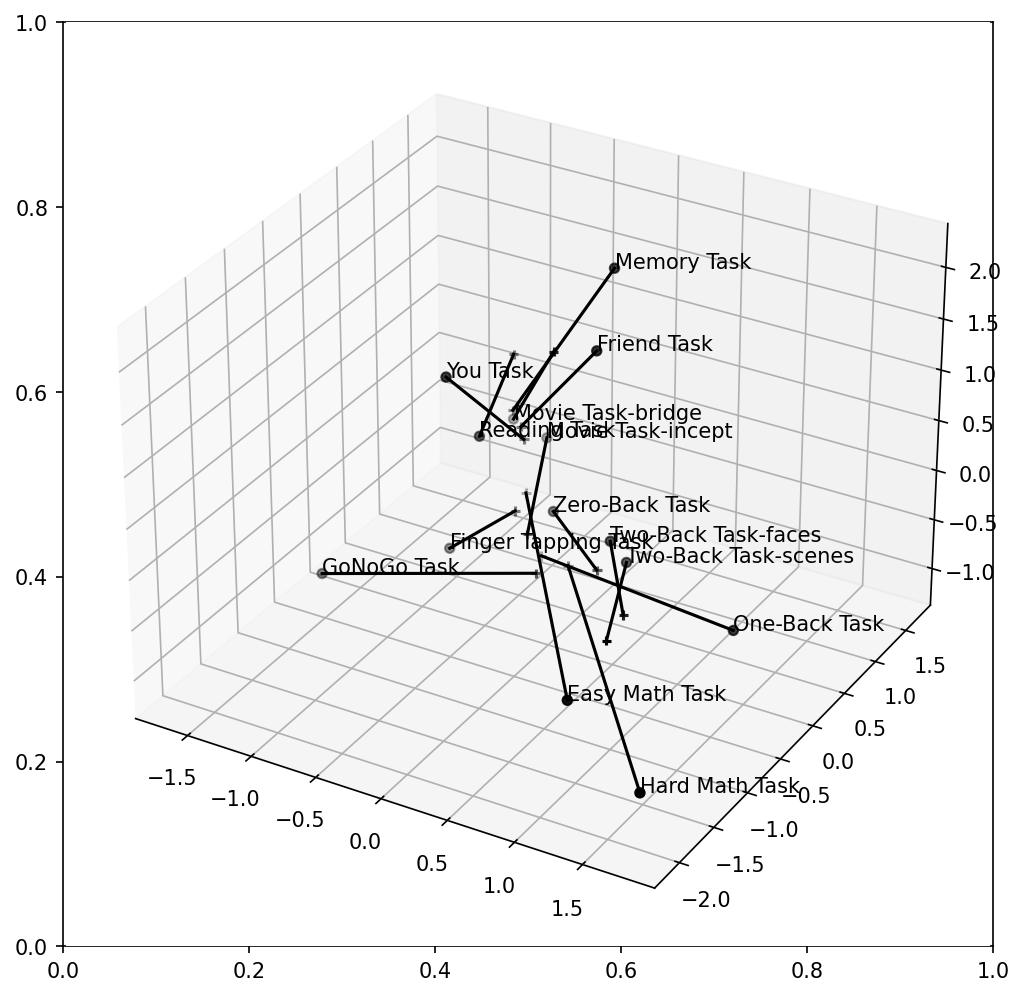

In [10]:


#Assess out of sample prediction with 3d gradient

fig, axs = plt.subplots(1,1,figsize=(8, 8), dpi=150)

k = tasknum
kf = KFold(n_splits=k, random_state=None)
numFac=4

X=Grad_TaskCentres
standardscaler=StandardScaler()
avg_acc_score=np.zeros([numFac])
pred_Fac=np.zeros([tasknum,numFac])
real_Fac=np.zeros([tasknum,numFac])

for i in range(numFac):
    acc_score = []
    y = standardscaler.fit_transform(FAC_TaskCentres[:,i].reshape(-1,1))    

    for train_index , test_index in kf.split(X):

        X_train , X_test = X[train_index,:],X[test_index,:]
        y_train , y_test = y[train_index] , y[test_index]

        kernel = 1.0 * Matern(length_scale=0.5, length_scale_bounds=(0.5, 1), nu=2.5)+ WhiteKernel(noise_level_bounds=[0.001,0.5],noise_level=0.05)
        gpr = GaussianProcessRegressor(kernel=kernel, random_state=3,normalize_y=False,alpha=0.0)
        
        @ignore_warnings(category=ConvergenceWarning)
        def __f():
            gpr.fit(X_train, y_train)
        __f()
        
        pred_values = gpr.predict(X_test)
        pred_Fac[test_index,i]=pred_values
        real_Fac[test_index,i]=y_test
        acc=np.abs(pred_values-y_test.T).sum()
        acc_score.append(acc)
        
    avg_acc_score[i] = np.median(acc_score)

ax = fig.add_subplot(1, 1, 1, projection='3d')

ax.scatter(pred_Fac[:,0],pred_Fac[:,1],pred_Fac[:,2],c='k',marker='+')
ax.scatter(real_Fac[:,0],real_Fac[:,1],real_Fac[:,2],c='k',marker='o')

for i in range(tasknum):
    ax.plot([pred_Fac[i,0],real_Fac[i,0]],[pred_Fac[i,1],real_Fac[i,1]],[pred_Fac[i,2],real_Fac[i,2]],c='k',marker='')
    ax.text(real_Fac[i,0],real_Fac[i,1],real_Fac[i,2],Tasklabels[i],c='k')
    

In [11]:
np.power(np.power(pred_Fac-real_Fac,2).mean(axis=1),0.5)

array([1.51277528, 0.68835435, 0.80411094, 1.09402505, 1.37051554,
       0.93600353, 1.47952918, 1.48041288, 0.85217078, 0.82360058,
       0.58507542, 0.53393999, 0.57688501, 0.53457277])

In [12]:
avg_acc_score

array([0.76792905, 0.627142  , 0.56287514, 0.76702258])

In [13]:

Tasklabels,Taskindices=np.unique(data.Task_name,return_inverse=True)
FAC_TaskCentres=np.zeros([tasknum,4])
for i in range(tasknum):
    FAC_TaskCentres[i,:]=FAC[Taskindices==i,:].mean(axis=0)

Grad_TaskCentres=np.zeros([tasknum,3])
for i in range(tasknum):
    Grad_TaskCentres[i,:]=GRAD[Taskindices==i,:].mean(axis=0)


In [14]:
from sklearn.model_selection import permutation_test_score

k = 4
kernel = 1.0 * Matern(length_scale=0.5, length_scale_bounds=(0.5, 1), nu=2.5) 
#kernel = 1.0 * Matern(length_scale=0.5, length_scale_bounds=(0.5, 1), nu=2.5)+ WhiteKernel(noise_level_bounds=[0.001,0.5],noise_level=0.05)
kf = KFold(n_splits=k, random_state=None)



gpr = GaussianProcessRegressor(kernel=kernel, random_state=None,normalize_y=True,alpha=0.1)
X=Grad_TaskCentres
scores = {}

for PCnum in range(FAC_TaskCentres.shape[1]):
    standardscaler=StandardScaler()

    y = FAC_TaskCentres[:,PCnum]
    
    @ignore_warnings(category=ConvergenceWarning)
    def ___f():
        score_gradfac, perm_scores_gradfac, pvalue_gradfac = permutation_test_score(gpr, X, y, scoring="neg_mean_absolute_error", cv=kf, n_permutations=1000)
    
        scores.update({PCnum:[score_gradfac,pvalue_gradfac]})
    
    ___f()




In [15]:
numloadings = 5
for score in scores:
    try:
        loading = loadings[score]
        loadingpos = loading.apply(lambda x: np.abs(x)).sort_values(ascending=False)
        tops = loading[loadingpos[:numloadings].index]
    except:
        tops = "Loadings from SPSS are unavailable"
    print(
        """
        Results for component {}:
        Largest loadings: 
        """.format(score)
        )
    with pd.option_context('display.max_rows', 5,
                       'display.max_columns', None,
                       'display.width', 1000,
                       'display.precision', 3,
                       'display.colheader_justify', 'center'):
        display(tops)
    print(
        """
        Permutation test score: {},
        Permutation test significance: {}
        """.format(scores[score][0],scores[score][1])
        )



        Results for component 0:
        Largest loadings: 
        


'Loadings from SPSS are unavailable'


        Permutation test score: -0.4279778905793572,
        Permutation test significance: 0.26173826173826176
        

        Results for component 1:
        Largest loadings: 
        


'Loadings from SPSS are unavailable'


        Permutation test score: -0.33015792598296295,
        Permutation test significance: 0.4145854145854146
        

        Results for component 2:
        Largest loadings: 
        


'Loadings from SPSS are unavailable'


        Permutation test score: -0.27372132016662665,
        Permutation test significance: 0.007992007992007992
        

        Results for component 3:
        Largest loadings: 
        


'Loadings from SPSS are unavailable'


        Permutation test score: -0.2774974925785198,
        Permutation test significance: 0.08091908091908091
        
